In [1]:
import torch
import warnings
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from zipfile import ZipFile
from PIL import Image
import yaml
from pathlib import Path


with open("cfg.yaml", "r") as file:
        cfg = yaml.safe_load(file)

sys.path.append("src/")


torch.manual_seed(1)
warnings.filterwarnings("ignore")

print(f"cuda is available: {torch.cuda.is_available()}")
print(f"mps is available: {torch.backends.mps.is_available()}")

import colorization_dataset
from net import VGG_Encoder, Decoder, Net
from train_and_test import train, test_model
# from inference_generation import test_transform, style_transfer


cuda is available: False
mps is available: True


In [2]:
train_data, test_data = colorization_dataset.prepare_dataset(train_size=cfg['train_size'], test_size=cfg['test_size'])
train_loader, _ = colorization_dataset.prepare_dataloader(train_data, test_data, batch_size=cfg['batch_size'])

'All tests passed'

Dataset loaded successfully
Data loader prepared successfully


In [3]:
train_image_lab= next(iter(train_loader))["image"][5]

In [4]:
print(train_image_lab[0].min(), train_image_lab[0].max())
print(train_image_lab[1].min(), train_image_lab[1].max())
print(train_image_lab[2].min(), train_image_lab[2].max())

tensor(0.) tensor(1.)
tensor(0.3324) tensor(0.6243)
tensor(0.3512) tensor(0.8155)


In [5]:
print(train_image_lab.permute(1,2,0).shape)

torch.Size([256, 256, 3])


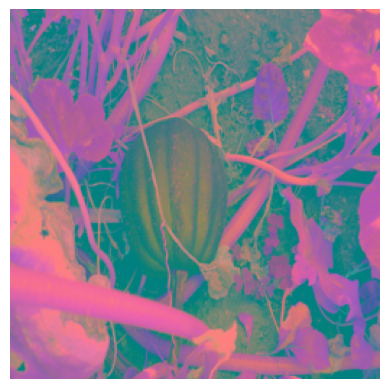

In [6]:
plt.imshow(train_image_lab.permute(1,2,0).numpy())
plt.axis('off')
plt.show()

In [7]:
labtorgb= colorization_dataset.LABtoRGB()
train_image_rgb= labtorgb(train_image_lab)

In [8]:
print(train_image_rgb[0].min(), train_image_rgb[0].max())
print(train_image_rgb[1].min(), train_image_rgb[1].max())
print(train_image_rgb[2].min(), train_image_rgb[2].max())

print(train_image_rgb.shape)

tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
torch.Size([3, 256, 256])


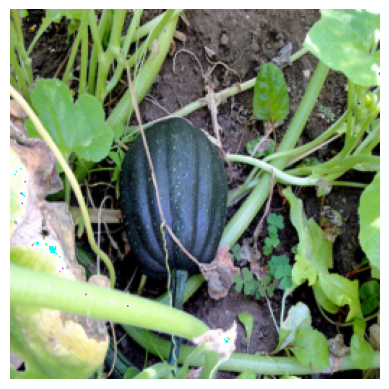

In [9]:
plt.imshow(train_image_rgb.permute(1,2,0).numpy())
plt.axis('off')
plt.show()

In [ ]:
encoder = VGG_Encoder()
decoder = Decoder()
net= Net(encoder, decoder)

train(net,cfg)

In [ ]:
encoder = VGG_Encoder()
decoder = Decoder()
#decoder.load_state_dict(torch.load(cfg["decoder"]))
net= Net(encoder, decoder)
net.enc_1.load_state_dict(torch.load(cfg["enc_1"]))
net.enc_2.load_state_dict(torch.load(cfg["enc_2"]))
net.enc_3.load_state_dict(torch.load(cfg["enc_3"]))
net.enc_4.load_state_dict(torch.load(cfg["enc_4"]))
net.decoder.load_state_dict(torch.load(cfg["decoder"]))

test_model(net, cfg)

Test

In [ ]:
# This are the image and the style I want to mix
# --> Set their path in cfg.yaml
input_img=Image.open("data/content_dir/brad_pitt.jpg")
display(input_img)
style_ref=Image.open("data/style_dir/brushstrokes.jpg")
display(style_ref)

device = torch.device("cuda" if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_built() else "cpu")

output_dir = Path(cfg["output_dir"])
output_dir.mkdir(exist_ok=True, parents=True)

# Either --content or --contentDir should be given.
assert (cfg["content"] or cfg["content_dir"])
if cfg["content"]:
    content_paths = [Path(cfg["content"])]
else:
    content_dir = Path(cfg["content_dir"])
    content_paths = [f for f in content_dir.glob('*')]

# Either --style or --styleDir should be given.
assert (cfg["style"] or cfg["style_dir"])
if cfg["style"]:
    style_paths = cfg["style"].split(',')
    if len(style_paths) == 1:
        style_paths = [Path(cfg["style"])]
    else:
        do_interpolation = True
        assert (cfg["style_interpolation_weights"] != ''), \
            'Please specify interpolation weights'
        weights = [int(i) for i in cfg["style_interpolation_weights"].split(',')]
        interpolation_weights = [w / sum(weights) for w in weights]
else:
    style_dir = Path(cfg["style_dir"])
    style_paths = [f for f in style_dir.glob('*')]

encoder = VGG_Encoder()
decoder = Decoder()

decoder.eval()
encoder.eval()

decoder.load_state_dict(torch.load(cfg["decoder"]))
# encoder.load_state_dict(torch.load(args.vgg))
#vgg = nn.Sequential(*list(vgg.children())[:31])

encoder.to(device)
decoder.to(device)

content_tf = test_transform(cfg["content_size"], cfg["crop"])
style_tf = test_transform(cfg["style_size"], cfg["crop"])

do_interpolation = False

for content_path in content_paths:

    # |||||||
    # not in use
    # |||||||
    # vvvvvvv
    if do_interpolation:  # one content image, N style image
        style = torch.stack([style_tf(Image.open(str(p))) for p in style_paths])
        content = content_tf(Image.open(str(content_path))) \
            .unsqueeze(0).expand_as(style)
        style = style.to(device)
        content = content.to(device)
        with torch.no_grad():
            output = style_transfer(encoder, decoder, content, style,
                                    cfg["alpha"], interpolation_weights)
        output = output.cpu()
        output_name = output_dir / '{:s}_interpolation{:s}'.format(
            content_path.stem, cfg["save_ext"])
        torchvision.utils.save_image(output, str(output_name))
    # ^^^^^^^
    # |||||||
    # not in use
    # |||||||
        

    else:  # process one content and one style
        for style_path in style_paths:
            content = content_tf(Image.open(str(content_path)))
            style = style_tf(Image.open(str(style_path)))
            #if cfg["preserve_color"]:
            #    style = coral(style, content)
            style = style.to(device).unsqueeze(0)
            content = content.to(device).unsqueeze(0)
            with torch.no_grad():
                output = style_transfer(encoder, decoder, content, style,
                                        cfg["alpha"])
            output = output.cpu()
            output_name = output_dir / '{:s}_stylized_{:s}{:s}'.format(
                content_path.stem, style_path.stem, cfg["save_ext"])
            torchvision.utils.save_image(output, str(output_name))

output_image=Image.open("data/output_dir/brad_pitt_stylized_brushstrokes.jpg")
display(output_image)
